In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk
import pickle

from nltk.corpus import stopwords

from collections import Counter, defaultdict
from scipy.sparse import save_npz, load_npz

from sklearn.decomposition import LatentDirichletAllocation, NMF, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.externals import joblib

%matplotlib inline

In [2]:
# nltk.download()  # 1 fois seulement

In [3]:
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [4]:
stemmer = nltk.stem.PorterStemmer()
tokenizer = nltk.RegexpTokenizer(r'(\w+|\d+)')

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    tokens = tokenizer.tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    return stems

# Exploration

In [5]:
train = pd.read_csv("dataset/train_set.csv")
test = pd.read_csv("dataset/test_set.csv")
tags = pd.read_csv("dataset/top104.csv") # tous les tags avec plus de 50k posts

In [6]:
train.head(5)

,Id,Title,Tags,Body
0,48550,How do I publish a Asp.NET web application usi...,<asp.net><.net><deployment><msbuild>,<p>I am trying to publish an Asp.net MVC web a...
1,48555,"Best way to compress HTML, CSS & JS with mod_d...",<php><html><apache><compression>,<p>I have a few sites on a shared host that is...
2,48562,How do I implement a pre-commit hook script in...,<python><svn><dos2unix>,<p>I was wondering if anyone here had some exp...
3,48570,Something like a callback delegate function in...,<php><oop>,<p>I would like to implement something similar...
4,48578,.NET MVC Ambiguous Type Reference,<asp.net-mvc>,<p>Not entirely sure what's going on here; any...


In [7]:
test.head(5)

,Id,Title,Tags,Body
0,10048916,Function for calling a function repeatedly?,<python><iterator><iteration>,<p>Consider the hypothetical function <code>re...
1,10048943,Proper Way to Retrieve More than 128 Documents...,<ravendb>,<p>I know variants of this question have been ...
2,10048958,Android calling AsyncTask right after an anoth...,<android><android-asynctask>,<p>I have some problem with Android AsyncTask....
3,10048967,Twitter Bootstrap2 100% height responsive,<mobile><desktop><twitter-bootstrap><responsiv...,<p>I want to make a responsive layout with twi...
4,10048978,Sending messages from PHP to Node.js,<php><node.js>,<p>How to send messages from php to node.js? ...


Pour le dataset d'entrainement et de test, on récupère 50000 posts au hasard pour l'entrainement et 50000 pour le test. Comme la fonction Rand() sur SQL utilise une seed fixe, on ne devrait pas avoir de doublons mais on peut verifier en regardant l'intersection des Id

In [8]:
# Verification des doublons
x1 = train["Id"].values
x2 = test["Id"].values
np.intersect1d(x1, x2)

array([], dtype=int64)

In [9]:
# On peut drop les IDs car ils ne servent qu'a s'assurer qu'il n'y a pas de doublons dans le test set
train.drop("Id", axis=1, inplace=True)
test.drop("Id", axis=1, inplace=True)

On peut regarder la repartition des labels dans les 2 datasets que ce soit au niveau des plus courant ou des moins courants

In [10]:
label_test = train["Tags"].str.replace("><", "*").str.replace("[><]*", "").str.split("*").tolist()
label_train = test["Tags"].str.replace("><", "*").str.replace("[><]*", "").str.split("*").tolist()

counter_train = Counter()
counter_test = Counter()

for post in label_train:
    for label in post:
        counter_train[label] += 1
        
for post in label_test:
    for label in post:
        counter_test[label] += 1

In [11]:
train_mc = counter_train.most_common(20)
test_mc = counter_test.most_common(20)

for i in range(20):
    print("Rank {:>2} - {:>12} vs {:<12}".format(i+1, train_mc[i][0], test_mc[i][0]))

Rank  1 -           c# vs c#          
Rank  2 -         java vs java        
Rank  3 -   javascript vs javascript  
Rank  4 -       python vs python      
Rank  5 -      android vs c++         
Rank  6 -          c++ vs .net        
Rank  7 -          php vs android     
Rank  8 -       jquery vs php         
Rank  9 -         .net vs jquery      
Rank 10 -          ios vs ios         
Rank 11 -         html vs html        
Rank 12 -            c vs c           
Rank 13 -          css vs asp.net     
Rank 14 -       iphone vs css         
Rank 15 -  objective-c vs sql         
Rank 16 -          sql vs objective-c 
Rank 17 -      asp.net vs iphone      
Rank 18 -        mysql vs sql-server  
Rank 19 - ruby-on-rails vs mysql       
Rank 20 -         ruby vs ruby        


On peut le représenter aussi comme une pyramide d'âge

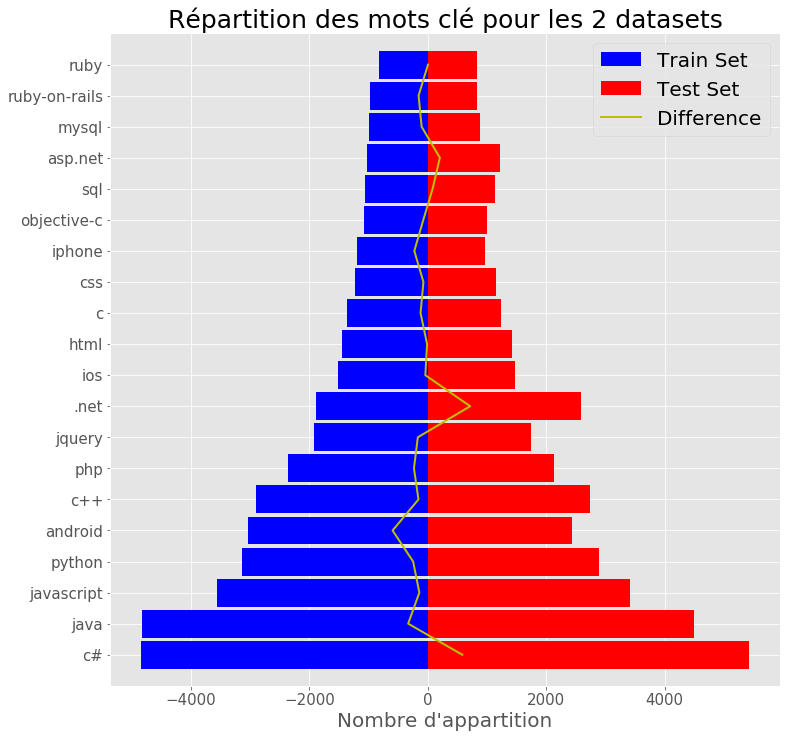

In [12]:
tag_label = []
v1 = []
v2 = []
somme = []

for tag, value in train_mc:
    tag_label.append(tag)
    v1.append(-value)
    v2.append(counter_test[tag])
    somme.append(v1[-1]+v2[-1])

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(12,12))
ValH = ax.barh(np.arange(len(v1)), v1, 0.9, label="Train Set", color='b', linewidth=0, align='center')
ValF = ax.barh(np.arange(len(v2)), v2, 0.9, label="Test Set", color='r', linewidth=0, align='center')
diff, = ax.plot(somme, np.arange(len(v2)),'y',linewidth=2)
ax.set_title("Répartition des mots clé pour les 2 datasets", fontsize=25)
plt.yticks( np.arange(len(tag_label)), tag_label, fontsize=15)
plt.ylim(-1,20)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
ax.set_xlabel("Nombre d'appartition", fontsize=20)
ax.legend((ValH[0],ValF[0],diff),('Train Set','Test Set','Difference'), fontsize=20)
plt.savefig("img/kword_pyramide.png")
plt.show()

On peut aussi utiliser la représentation plus classique avec les stacked bar

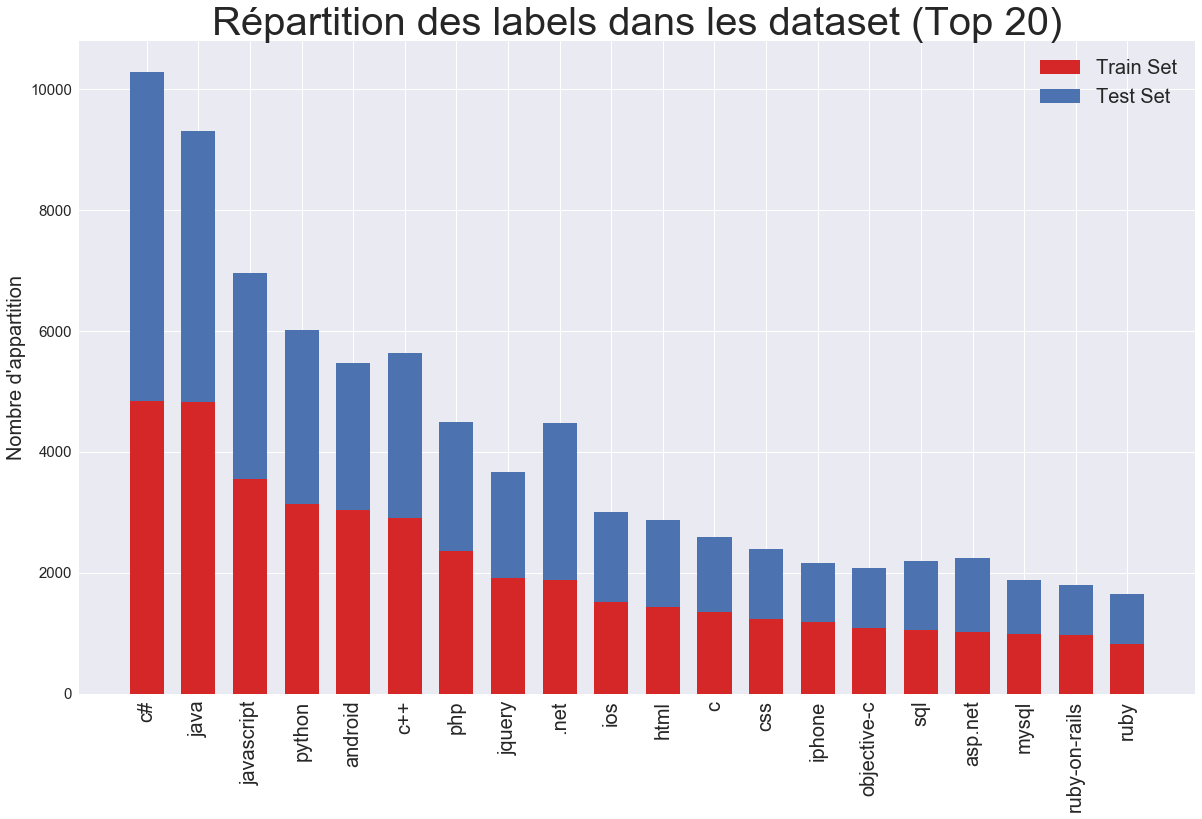

In [15]:
N = 20

train_freq = []
test_freq = []
labels = []

mc = list(zip(*counter_train.most_common(N)))

for label, freq in zip(mc[0], mc[1]):
    train_freq.append(freq)
    test_freq.append(counter_test[label])
    labels.append(label)

ind = np.arange(N)    # the x locations for the groups
width = 0.66      # the width of the bars: can also be len(x) sequence

plt.style.use('seaborn')

fig, ax = plt.subplots(figsize=(20,12))
p1 = plt.bar(ind, train_freq, width, color='#d62728')
p2 = plt.bar(ind, test_freq, width,  bottom=train_freq)

plt.ylabel("Nombre d'appartition", fontsize=20)
plt.title("Répartition des labels dans les dataset (Top {})".format(N), fontsize=40)
plt.xticks(ind, labels, rotation='vertical', fontsize=20)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
plt.legend((p1[0], p2[0]), ('Train Set', 'Test Set'), fontsize=20)
plt.savefig("img/repartition_keyword.png")
plt.show()

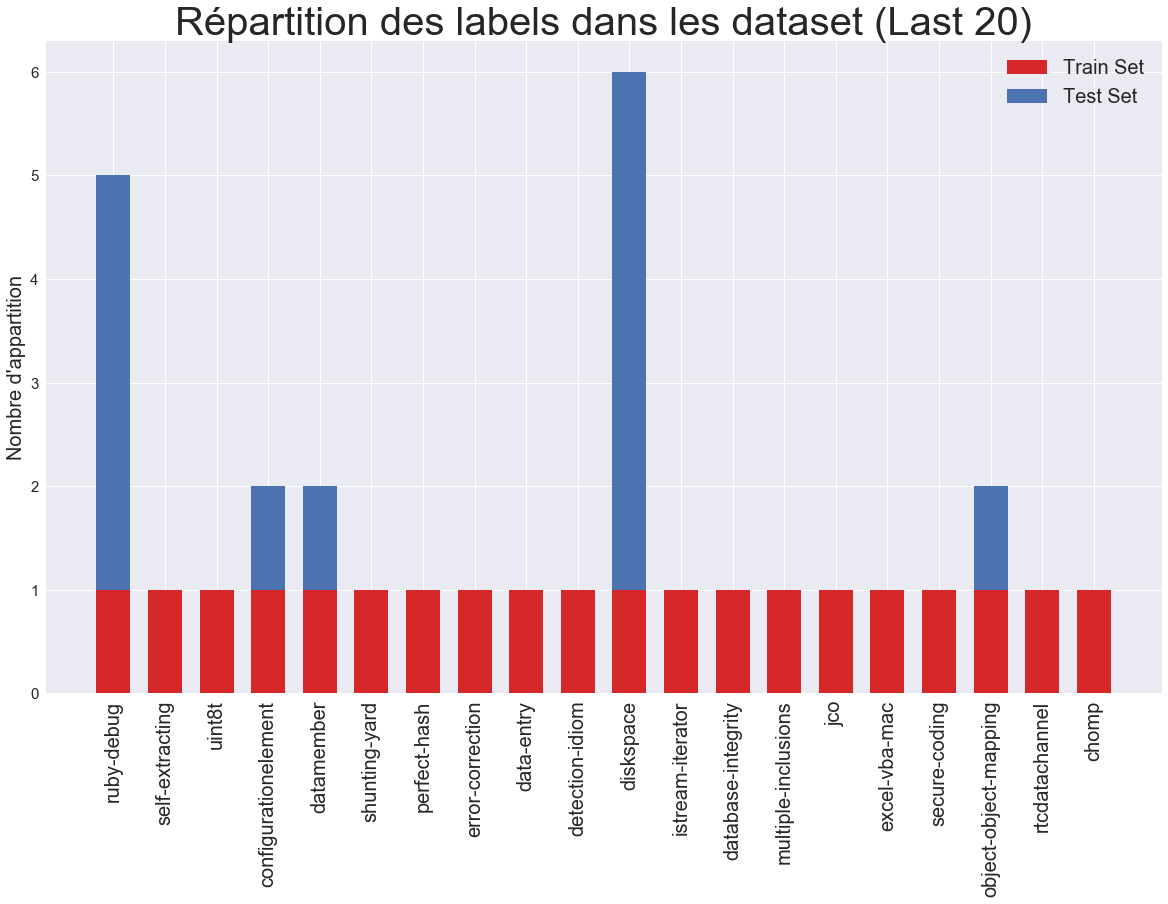

In [16]:
N = 20

train_freq = []
test_freq = []
labels = []

mc = list(zip(*counter_train.most_common()[:-N-1:-1]))

for label, freq in zip(mc[0], mc[1]):
    train_freq.append(freq)
    test_freq.append(counter_test.get(label, 0))
    labels.append(label)

ind = np.arange(N)    # the x locations for the groups
width = 0.66      # the width of the bars: can also be len(x) sequence

plt.style.use('seaborn')

fig, ax = plt.subplots(figsize=(20,12))
p1 = plt.bar(ind, train_freq, width, color='#d62728')
p2 = plt.bar(ind, test_freq, width,  bottom=train_freq)

plt.ylabel("Nombre d'appartition", fontsize=20)
plt.title("Répartition des labels dans les dataset (Last {})".format(N), fontsize=40)
plt.xticks(ind, labels, rotation='vertical', fontsize=20)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
plt.legend((p1[0], p2[0]), ('Train Set', 'Test Set'), fontsize=20)
plt.savefig("img/repartition_keyword_end.png")
plt.show()

# Cleanup

## Title

On va fusionner le titre avec le body. On pourra donc supprimer cette feature

In [17]:
train["Body"] = train["Title"] + " " + train['Body']
test["Body"] = test["Title"] + " " + test['Body']

In [18]:
train.drop(["Title"], axis=1, inplace=True)
test.drop(["Title"], axis=1, inplace=True)

## Tags

Concernant les tags, on va garder tous les tags qui ont plus de 25 appartitions dans le train test. Les posts n'ayant plus de mots clés après nettoyage seront supprimés. Le test set lui sera filtré par rapport aux mots clé fréquent du train set.

In [19]:
taglist = tags["TagName"].tolist()

In [20]:
labels = train["Tags"].str.replace("><", "*").str.replace("[><]*", "").str.split("*").tolist()

In [21]:
empty = 0
empty_counter = Counter()
added = []
index = []
for i, tl in enumerate(labels):
    for key in tl:
        if key not in taglist:
            empty_counter[key] += 1

for key, freq in empty_counter.items():
    if freq > 25:
        added.append(key)

taglist += added
for i, tl in enumerate(labels):
    labels[i] = [word for word in tl if word in taglist]
    if len(labels[i]) == 0:
        empty += 1
        index.append(i)
        for tag in tl:
            empty_counter[tag] += 1
print(empty)

1643


Après conservation des mots clés principuax, on a 637 posts sans tags que l'on doit supprimer. On peut regarder le nombre de tags que l'on conserve

In [22]:
counter_class = Counter()
for post in labels:
    for label in post:
        counter_class[label] += 1
        
len(counter_class)

773

773 tags sont conservés par la suite. On peut donc supprimer les lignes n'ayant pas de tags

In [23]:
train = train.drop(train.index[index]).reset_index(drop=True)

save_obj(taglist, "datas/taglist")

On fait donc le même nettoyage sur le test set

In [24]:
labels = test["Tags"].str.replace("><", "*").str.replace("[><]*", "").str.split("*").tolist()

In [25]:
for i, tl in enumerate(labels):
    labels[i] = [word for word in tl if word in taglist]
    if len(labels[i]) == 0:
        empty += 1
        index.append(i)
        for tag in tl:
            empty_counter[tag] += 1
print(empty)

3418


In [26]:
test = test.drop(test.index[index]).reset_index(drop=True)

## Body

In [27]:
train["Body"] = train["Body"].str.replace("<code>[^<]*</code>", "")
test["Body"] = test["Body"].str.replace("<code>[^<]*</code>", "")

In [28]:
train["Body"] = train["Body"].str.replace("<[^>]*>", "")
test["Body"] = test["Body"].str.replace("<[^>]*>", "")

In [29]:
train["Body"] = train["Body"].str.replace("\r", "").str.replace("\n", "")
test["Body"] = test["Body"].str.replace("\r", "").str.replace("\n", "")

In [30]:
train["Body"].iloc[0]

'How do I publish a Asp.NET web application using MSBuild? I am trying to publish an Asp.net MVC web application locally using the NAnt and MSBuild. This is what I am using for my NAnt target;and all I get is this as a response;Is it possible to publish web applications via the command line in this way?'

In [31]:
train.to_csv("dataset/train_set_clean.csv", index=False, encoding="utf_16")
test.to_csv("dataset/test_set_clean.csv", index=False, encoding="utf_16")

In [32]:
# Si besoin

# train = pd.read_csv("train_set_clean_long.csv", encoding="utf_16")
# test = pd.read_csv("test_set_clean_long.csv", encoding="utf_16")

# Preparation des sets

In [33]:
X_train = train["Body"].tolist()
X_test = test["Body"].tolist()

In [35]:
y_train = train["Tags"].str.replace("><", "*").str.replace("[><]*", "").str.split("*").tolist()
y_test = test["Tags"].str.replace("><", "*").str.replace("[><]*", "").str.split("*").tolist()

In [36]:
y_train_clean = []
for i, tl in enumerate(y_train):
    y_train_clean.append([word for word in tl if word in taglist])
    
y_test_clean = []
for i, tl in enumerate(y_test):
    y_test_clean.append([word for word in tl if word in taglist])

In [37]:
save_obj(X_train, "datas/X_train")
save_obj(X_test, "datas/X_test")
save_obj(y_train_clean, "datas/y_train")
save_obj(y_test_clean, "datas/y_test")

In [38]:
# from sklearn.preprocessing import MultiLabelBinarizer

# mlb = MultiLabelBinarizer()
# mlb.fit(y_train_clean)

# joblib.dump(mlb, "MultiLabelBinarizer")

# Preparation des matrices

On a préparé precedemment un array de texte "nettoyé" et un array de array de tags que l'on a sauvegardé via pickle. Pour la suite on peut reprendre directement ici et charger juste les données.

## Loading datas

In [17]:
X_train = load_obj("datas/X_train")
y_train = load_obj("datas/y_train")

taglist = load_obj("datas/taglist")

y_train_clean = load_obj("datas/y_train")
y_test_clean = load_obj("datas/y_test")

mlb = joblib.load("models/MultiLabelBinarizer")
y_train = mlb.transform(y_train_clean)
y_test = mlb.transform(y_test_clean)

print(y_train.shape)
print(y_test.shape)

(48357, 773)
(46645, 773)


## Préparation TF matrice

Cette section est commentée car très consommatrice en temps de calcul. Chaque resultat a été sauvegardé et est rechargé à la fin

Dasn un 1er temps, on peut ajouter aux Stop_words le top 100 des mots les plus utilisés

In [53]:
# count = Counter()
# tokenizer = nltk.RegexpTokenizer(r'\w+')

# for i, sentence in enumerate(X_train):
#     tokenized = tokenizer.tokenize(sentence)
#     for word in tokenized:
#         count[word] += 1

# stop = set(stopwords.words('english')) | set([word for word, freq in count.most_common(100)])

# save_obj(stop, "datas/stopwords")

Pour la matrice TF, on ne va pas utiliser le tokeniser pour garder les mots clé intact qui serviront pour le LDA (on ne gagne pas beaucoup de dimensions avec ou sans)

In [42]:
# count_vect = CountVectorizer(tokenizer=None, stop_words=stop)
# tf_Matrix = count_vect.fit_transform(X_train)

In [43]:
# tf_Matrix

<48357x91349 sparse matrix of type '<class 'numpy.int64'>'
	with 1719533 stored elements in Compressed Sparse Row format>

In [50]:
# joblib.dump(count_vect, "models/CountVectorizer")
# save_npz('datas/tf_Matrix.npz', tf_Matrix)

## Préparation TF-IDF matrice

Pour le TF-IDF, on doit utiliser un tokenizer car les mots sont comparés autre entre documents. Du coup, si on a la meme racine dans plusieurs documents, leur interet diminuera. Sans tokenisation, certains mots seront classé différement juste à cause du pluriel par exemple

In [47]:
# tfidf = TfidfVectorizer(min_df = 0.001, tokenizer=tokenize, stop_words=stop)
# tfidfMatrix = tfidf.fit_transform(X_train)

In [48]:
# tfidfMatrix

<48357x2764 sparse matrix of type '<class 'numpy.float64'>'
	with 1547633 stored elements in Compressed Sparse Row format>

In [51]:
# joblib.dump(tfidf, "models/TfidfVectorizer")
# save_npz('datas/tfidfMatrix.npz', tfidfMatrix)

## Reduction de dimensions  - LSA

A l'instar du PCA, on peut essayer de réduire les dimensions avec le LSA / TSVD (https://en.wikipedia.org/wiki/Latent_semantic_analysis)

In [58]:
# svd = TruncatedSVD(n_components = 3000)
# svdMatrix = svd.fit_transform(tf_Matrix)

In [59]:
# np.cumsum(svd.explained_variance_ratio_)

array([ 0.04654721,  0.05742402,  0.071104  , ...,  0.88463928,
        0.88467341,  0.88470747])

La TF matrice a pour shape 48357x91349 très sparse. Le LSA permet de réduire les dimensions en ne gardant que les mots importants. A l'instart du PCA, on peut regarder la variance maintenue en fonction du nombre de dimensions. 
Dans notre cas 3000 dimensions conservent 88% de la variance. On peut garder cette solution en tête pour la suite si on a des soucis de mémoire ou temps de calcul.

In [64]:
# joblib.dump(svd, "models/TruncatedSVD")
# np.save('datas/svdMatrix.npy', svdMatrix)